In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'

# Debt Market Model

The purpose of this notebook is to configure and simulate the full CDP and APT system model, using the historical Ethereum price as a driver, under different PI controller settings - enabled, disabled, `kp` and `ki`.

# Setup and Dependencies

In [2]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Force reload of project modules, sometimes necessary for Jupyter kernel
%load_ext autoreload
%autoreload 2

# Display cadCAD version for easy debugging
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages
Requires: fn, pathos, pandas, funcy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import all shared dependencies and setup
from shared import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import plotly.io as pio
# pio.renderers.default = "png"

# Historical MakerDAO Dai debt market activity

In [4]:
# Import the historical MakerDAO market data CSV file
from models.system_model_v3.model.state_variables.historical_state import debt_market_df
debt_market_df

/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


seconds_passed    rho_star   beta         p             Q  \
date                                                                    
2017-12-18           86400  736.004090  0.005  1.017605  2.425662e+03   
2017-12-19           86400  832.236972  0.005  1.003376  6.240431e+03   
2017-12-20           86400  810.287507  0.005  1.012972  1.418307e+04   
2017-12-21           86400  837.231080  0.005  1.025738  1.564473e+04   
2017-12-22           86400  689.014990  0.005  0.972228  1.883084e+04   
...                    ...         ...    ...       ...           ...   
2019-09-26           86400  167.637314  0.125  1.021405  1.525944e+06   
2019-09-27           86400  167.347085  0.125  1.007346  1.529959e+06   
2019-09-28           86400  174.289775  0.125  1.011006  1.528450e+06   
2019-09-29           86400  171.054119  0.105  1.013604  1.529013e+06   
2019-09-30           86400  173.096419  0.105  1.007126  1.531726e+06   

                     v_1     v_2 + v_3           u_1     u_2 + u_3  \
date                                                                 
2017-12-18   2526.662000    101.000000  5.953420e+05  4.594384e+01   
2017-12-19   3821.320309      6.550995  1.379832e+06  3.539448e+04   
2017-12-20   8066.895210    124.255903  2.676383e+06  5.022518e+05   
2017-12-21   1471.742069     10.080000  8.053550e+05  4.978271e+04   
2017-12-22   5316.960481   2130.848985  3.145512e+05  7.474531e+05   
...                  ...           ...           ...           ...   
2019-09-26  56696.770732  29566.578527  8.079170e+05  1.585480e+06   
2019-09-27   7598.158072   3582.812664  6.087607e+05  6.367461e+05   
2019-09-28    876.961579   2386.452089  2.251956e+05  1.452312e+05   
2019-09-29   2263.584945   1700.812508  1.357774e+05  1.699417e+05   
2019-09-30   4436.484054   1722.801186  6.848752e+05  1.920650e+05   

                     u_2  ...           u_3          w_3     w_2 + w_3  \
date                      ...                                            
2017-12-18  1.000000e+01  ...     35.943840     0.000023      0.000029   
2017-12-19  3.536748e+04  ...     27.000000     0.000348      0.456233   
2017-12-20  5.014128e+05  ...    839.000000     0.000299      0.179179   
2017-12-21  4.978271e+04  ...      0.000000     0.000000      1.158909   
2017-12-22  7.239153e+05  ...  23537.818000     0.642374     20.398842   
...                  ...  ...           ...          ...           ...   
2019-09-26  1.515115e+06  ...  70364.380268  2984.212338  67241.524162   
2019-09-27  6.366783e+05  ...     67.790257     0.768156   7215.198255   
2019-09-28  1.452062e+05  ...     25.000000     0.084809    492.674170   
2019-09-29  1.699335e+05  ...      8.108662     0.123176   2581.527301   
2019-09-30  1.920636e+05  ...      1.400000     0.009118   1250.952959   

                     D_1           D_2           w_1             D  \
date                                                                 
2017-12-18  5.952961e+05  0.000000e+00      0.000000  5.952961e+05   
2017-12-19  1.939733e+06  2.604943e+01     26.505662  1.939759e+06   
2017-12-20  4.113865e+06  8.208488e+01     56.214632  4.113947e+06   
2017-12-21  4.869437e+06  1.474660e+02     66.539983  4.869584e+06   
2017-12-22  4.436535e+06  1.876926e+02     60.625449  4.436723e+06   
...                  ...           ...           ...           ...   
2019-09-26  7.957442e+07  4.562428e+06  27167.708945  8.413685e+07   
2019-09-27  7.954644e+07  4.582358e+06  27145.743151  8.412880e+07   
2019-09-28  7.962640e+07  4.609044e+06  27177.983765  8.423545e+07   
2019-09-29  7.959224e+07  4.629498e+06  23036.315844  8.422174e+07   
2019-09-30  8.008505e+07  4.651424e+06  23176.738113  8.473647e+07   

                  C_star  p_star  p_ema_10  
date                                        
2017-12-18  1.785297e+06       1  1.008573  
2017-12-19  5.193518e+06       1  1.008573  
2017-12-20  1.149236e+07       1  1.008573  
2017-12-21  1.309826e+07       1  1.008573  
2017-12

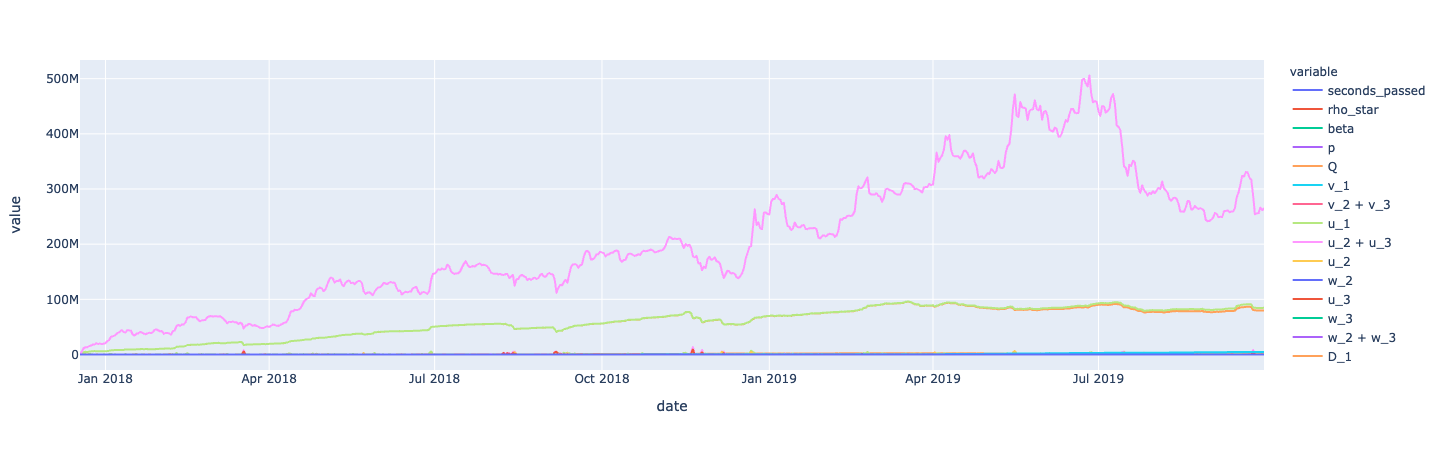

In [5]:
# Plot the full set of historical data over time
debt_market_df.plot()

# Model Configuration

In [6]:
from models.system_model_v3.model.state_variables.init import state_variables

state_variables.update({})


130417.5685990905
189872.3149593018
29727.37318010564
29727.37318010564


19377432.0069828
42320205.44783997
16068921.349645888
6873852.091211276



In [7]:
from models.system_model_v3.model.params.init import params

# Update the default parameter values
params_update = {
    'controller_enabled': [True],
    'kp': [5e-7], # proportional term for the stability controller: units 1/USD
    'ki': [lambda control_period=3600: -1e-7 / control_period], # integral term for the stability controller: units 1/(USD*seconds)
}

params.update(params_update)

# Simulation Execution

In [8]:
# Set the number of simulation timesteps, with a maximum of `len(debt_market_df) - 1`
SIMULATION_TIMESTEPS = 10 # len(debt_market_df) - 1

In [9]:
# Create a wrapper for the model simulation, and update the existing parameters and initial state
system_simulation = ConfigWrapper(system_model_v3, T=range(SIMULATION_TIMESTEPS), M=params, initial_state=state_variables)

In [10]:
del configs[:] # Clear any prior configs
system_simulation.append() # Append the simulation config to the cadCAD `configs` list
(simulation_result, _tensor_field, _sessions) = run(drop_midsteps=False) # Run the simulation

INFO:root:Started simulation
DEBUG:root:expected_market_price terms: (1, 1.0, 1.0, 3.86810578185312e-06, 365.8127290676168, 383.822378472222, 0.6756295152422528, 1.0004125645956772, 0, 1.0002090775887924)
DEBUG:root:
    ##### APT model run #####
    Timestep: 1
    
DEBUG:root:
    feature_0: [[5.00000000e-03 1.30417569e+05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.93774320e+07]]
    x0: [0. 0. 0. 0.]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 1.0002090775887924
    
/Users/bscholtz/workspace/reflexer/models/system_model_v3/model/parts/apt_model.py:119: OptimizeWarning:

Initial guess is not within the specified bounds




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 40, 1, 43)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded


DEBUG:root:
            Success: False
            Message: Maximum number of function evaluations has been exceeded.
            Function value: 0.00028809220385972445
            
DEBUG:root:
    x_star: [7.13016202e+06 2.67727084e+05 1.66213875e+05 8.51257934e+02]
    optimal_values: {'u_1': 7130162.024373357, 'u_2': 267727.08409593493, 'v_1': 166213.87486605, 'v_2 + v_3': 851.2579337737952}
    


DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2621; Number of closed CDPs: 0
DEBUG:root:--- 83.4727840423584 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2621; Number of closed CDPs: 0
DEBUG:root:expected_debt_price: 1.0027746707201004
DEBUG:root:expected_market_price terms: (1, 1.0012950286036022, 1.0, 3.86810578185312e-06, 365.8127290676168, 386.787114583333, 0.6756295152422528, 1.0004125645956772, 0, 1.0006168015443664)
DEBUG:root:
    ##### APT model run #####
    Timestep: 2
    
DEBUG:root:
    feature_0: [[5.00000000e-03 2.95780186e+05 1.66213875e+05 8.51257934e+02
  7.13016202e+06 2.67727084e+05 0.00000000e+00 3.63120195e+02
  0.00000000e+00 0.00000000e+00 3.78426169e+07]]
    x0: [7.13016202e+06 2.67727084e+05 1.66213875e+05 8.51257934e+02]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 1.0006168015443664
    
DEBUG:root:
            Success: False
    

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2629; Number of closed CDPs: 0
DEBUG:root:--- 86.10810208320618 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2629; Number of closed CDPs: 0
DEBUG:root:expected_debt_price: 0.9994206577539444
DEBUG:root:expected_market_price terms: (1, 1.000047462752581, 1.0, 3.86810578185312e-06, 365.8127290676168, 402.818423611111, 0.6756295152422528, 1.0004125645956772, 0, 1.0001509993067177)
DEBUG:root:
    ##### APT model run #####
    Timestep: 3
    
DEBUG:root:
    feature_0: [[5.00000000e-03 3.31693894e+05 3.61446388e+04 2.30930371e+02
  3.94626478e+06 3.16506360e+05 0.00000000e+00 2.46208389e+02
  3.63120195e+02 0.00000000e+00 4.27679119e+07]]
    x0: [3.94626478e+06 3.16506360e+05 3.61446388e+04 2.30930371e+02]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 1.0001509993067177
    
DEBUG:root:
            Success: False
    

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2630; Number of closed CDPs: 0
DEBUG:root:--- 86.27562069892883 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2630; Number of closed CDPs: 0
DEBUG:root:expected_debt_price: 0.9980243090540171
DEBUG:root:expected_market_price terms: (1, 0.9990148369745372, 1.0, 3.86810578185312e-06, 365.8127290676168, 392.54599305555604, 0.6756295152422528, 1.0004125645956772, 0, 0.9998549474546967)
DEBUG:root:
    ##### APT model run #####
    Timestep: 4
    
DEBUG:root:
    feature_0: [[5.00000000e-03 4.38199756e+05 1.08187715e+05 1.32169810e+02
  4.16181725e+05 3.49514806e+05 0.00000000e+00 2.05940472e+01
  2.46208389e+02 0.00000000e+00 5.88422443e+07]]
    x0: [4.16181725e+05 3.49514806e+05 1.08187715e+05 1.32169810e+02]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 0.9998549474546967
    
DEBUG:root:
            Success: False
 

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2636; Number of closed CDPs: 0
DEBUG:root:--- 97.58753895759583 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2636; Number of closed CDPs: 0
DEBUG:root:expected_debt_price: 1.0013254843652248
DEBUG:root:expected_market_price terms: (1, 0.9997765928885467, 1.0, 3.86810578185312e-06, 365.8127290676168, 379.389607638889, 0.6756295152422528, 1.0004125645956772, 0, 1.0001536730810208)
DEBUG:root:
    ##### APT model run #####
    Timestep: 5
    
DEBUG:root:
    feature_0: [[5.00000000e-03 5.52842897e+05 1.14841120e+05 1.97979190e+02
  2.64988155e+06 3.27087222e+05 0.00000000e+00 2.58427896e+02
  2.27373675e-13 0.00000000e+00 7.23406864e+07]]
    x0: [2.64988155e+06 3.27087222e+05 1.14841120e+05 1.97979190e+02]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 1.0001536730810208
    
DEBUG:root:
            Success: False
   

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2638; Number of closed CDPs: 0
DEBUG:root:--- 86.8467481136322 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2638; Number of closed CDPs: 0
DEBUG:root:expected_debt_price: 0.9969201162457466
DEBUG:root:expected_market_price terms: (1, 0.9976144133746505, 1.0, 3.86810578185312e-06, 365.8127290676168, 372.4797743055549, 0.6756295152422528, 1.0004125645956772, 0, 0.9994746896291101)
DEBUG:root:
    ##### APT model run #####
    Timestep: 6
    
DEBUG:root:
    feature_0: [[5.00000000e-03 5.93212571e+05 5.08295363e+04 1.03927663e+04
  1.69702192e+04 1.03115586e+06 0.00000000e+00 1.69313995e+02
  0.00000000e+00 0.00000000e+00 7.50216988e+07]]
    x0: [  16970.2192429  1031155.86378215   50829.53628955   10392.76632683]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 0.9994746896291101
    
DEBUG:root:
            Success: F

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2641; Number of closed CDPs: 0
DEBUG:root:--- 92.16423988342285 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2641; Number of closed CDPs: 0
DEBUG:root:expected_debt_price: 1.0003646202385426
DEBUG:root:expected_market_price terms: (1, 0.9993128141364069, 1.0, 3.86810578185312e-06, 365.8127290676168, 383.895659649122, 0.6756295152422528, 1.0004125645956772, 0, 0.9999854287886318)
DEBUG:root:
    ##### APT model run #####
    Timestep: 7
    
DEBUG:root:
    feature_0: [[5.00000000e-03 6.84808072e+05 1.02845278e+05 1.12497773e+04
  1.13188012e+06 1.03058007e+06 0.00000000e+00 8.53262327e+01
  0.00000000e+00 0.00000000e+00 8.50208560e+07]]
    x0: [1131880.11909676 1030580.07036293  102845.27808797   11249.7773033 ]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 0.9999854287886318
    
DEBUG:root:
            Success: F

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2642; Number of closed CDPs: 2
DEBUG:root:--- 90.94208002090454 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2642; Number of closed CDPs: 2
DEBUG:root:expected_debt_price: 1.0005288943648338
DEBUG:root:expected_market_price terms: (1, 0.9993670501217663, 1.0, 3.86810578185312e-06, 365.8127290676168, 394.432557894737, 0.6756295152422528, 1.0004125645956772, 0, 0.9999623490005958)
DEBUG:root:
    ##### APT model run #####
    Timestep: 8
    
DEBUG:root:
    feature_0: [[5.00000000e-03 7.75516971e+05 1.02844782e+05 1.21358827e+04
  1.89669321e+06 1.05586887e+06 0.00000000e+00 1.53260438e+02
  5.33662171e+02 0.00000000e+00 9.92329264e+07]]
    x0: [1896693.20996611 1055868.87479082  102844.78156941   12135.88270516]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 0.9999623490005958
    
DEBUG:root:
            Success: F

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2643; Number of closed CDPs: 2
DEBUG:root:--- 87.3003659248352 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2643; Number of closed CDPs: 2
DEBUG:root:expected_debt_price: 0.9961049556732178
DEBUG:root:expected_market_price terms: (1, 0.9979043457792277, 1.0, 3.86810578185312e-06, 365.8127290676168, 404.209204861111, 0.6756295152422528, 1.0004125645956772, 0, 0.999447210710749)
DEBUG:root:
    ##### APT model run #####
    Timestep: 9
    
DEBUG:root:
    feature_0: [[5.00000000e-03 8.42777256e+05 1.00952002e+05 3.35364635e+04
  4.08197277e+04 2.38209894e+06 0.00000000e+00 1.83439233e+02
  1.53260438e+02 0.00000000e+00 1.10799501e+08]]
    x0: [  40819.72766319 2382098.94205535  100952.00170417   33536.46352316]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 0.999447210710749
    
DEBUG:root:
            Success: Fals

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2644; Number of closed CDPs: 2
DEBUG:root:--- 92.6253650188446 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2644; Number of closed CDPs: 2
DEBUG:root:expected_debt_price: 0.9994713198393583
DEBUG:root:expected_market_price terms: (1, 0.9981912614028873, 1.0, 3.86810578185312e-06, 365.8127290676168, 402.394802083333, 0.6756295152422528, 1.0004125645956772, 0, 0.999548077501532)
DEBUG:root:
    ##### APT model run #####
    Timestep: 10
    
DEBUG:root:
    feature_0: [[5.00000000e-03 9.22010368e+05 1.01905433e+05 2.23107350e+04
  9.74258708e+04 2.38307732e+06 0.00000000e+00 1.91450679e+02
  1.83439233e+02 0.00000000e+00 1.24214320e+08]]
    x0: [  97425.87079962 2383077.31993471  101905.43334512   22310.73504089]
    optvars: ['u_1', 'u_2', 'v_1', 'v_2 + v_3']
    expected_market_price: 0.999548077501532
    
DEBUG:root:
            Success: Fal

DEBUG:root:resolve_cdp_positions() ~ Number of open CDPs: 2646; Number of closed CDPs: 2
DEBUG:root:--- 83.5611720085144 seconds ---
DEBUG:root:0 CDPs liquidated with v_2 0.0 v_3 0.0 u_3 0.0 w_3 0.0
DEBUG:root:p_rebalance_cdps() ~ Number of open CDPs: 2646; Number of closed CDPs: 2
DEBUG:root:expected_debt_price: 0.9982181005179882
INFO:root:Finished simulation


Total execution time: 904.87s


# Simulation Analysis

In [11]:
# Add new columns to dataframe
simulation_result = simulation_result.assign(eth_collateral_value = simulation_result.eth_collateral * simulation_result.eth_price)
simulation_result['collateralization_ratio'] = (simulation_result.eth_collateral * simulation_result.eth_price) / (simulation_result.principal_debt * simulation_result.target_price)

# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

simulation_result

index events                                        cdp_metrics  \
0        0   None                                                 {}   
1        1   None                                                 {}   
2        2   None                                                 {}   
3        3   None                                                 {}   
4        4   None                                                 {}   
..     ...    ...                                                ...   
176    176     []  {'cdp_count': 2646, 'open_cdp_count': 2644, 'c...   
177    177     []  {'cdp_count': 2646, 'open_cdp_count': 2644, 'c...   
178    178     []  {'cdp_count': 2646, 'open_cdp_count': 2644, 'c...   
179    179     []  {'cdp_count': 2648, 'open_cdp_count': 2646, 'c...   
180    180     []  {'cdp_count': 2648, 'open_cdp_count': 2646, 'c...   

                                        feature_vector  \
0                                                   {}   
1                                                   {}   
2                                                   {}   
3                                                   {}   
4    [[0.005, 130417.5685990905, 166213.87486605, 8...   
..                                                 ...   
176  [[0.005, 922010.3677834794, 101422.68864928144...   
177  [[0.005, 922010.3677834794, 101422.68864928144...   
178  [[0.005, 922010.3677834794, 101422.68864928144...   
179  [[0.005, 922010.3677834794, 101422.68864928144...   
180  [[0.005, 922010.3677834794, 101422.68864928144...   

                                        optimal_values  \
0                                                   {}   
1                                                   {}   
2                                                   {}   
3                                                   {}   
4    {'u_1': 7130162.024373357, 'u_2': 267727.08409...   
..                                                 ...   
176  {'u_1': 28930.567465738335, 'u_2': 3358566.682...   
177  {'u_1': 28930.567465738335, 'u_2': 3358566.682...   
178  {'u_1': 28930.567465738335, 'u_2': 3358566.682...   
179  {'u_1': 28930.567465738335, 'u_2': 3358566.682...   
180  {'u_1': 28930.567465738335, 'u_2': 3358566.682...   

                                      minimize_results  timedelta  \
0                                                   {}        0.0   
1                                                   {}        0.0   
2                                                   {}    86400.0   
3                                                   {}    86400.0   
4    {'fun': 0.00028809220385972445, 'direc': [[1.0...    86400.0   
..                                                 ...        ...   
176  {'fun': 7.26812315332559e-06, 'direc': [[1.0, ...    86400.0   
177  {'fun': 7.26812315332559e-06, 'direc': [[1.0, ...    86400.0   
178  {'fun': 7.26812315332559e-06, 'direc': [[1.0, ...    86400.0   
179  {'fun': 7.26812315332559e-06, 'direc': [[1.0, ...    86400.0   
180  {'fun': 7.26812315332559e-06, 'direc': [[1.0, ...    86400.0   

     cumulative_time  timestamp  blockheight   eth_price  \
0                0.0 2018-04-01            0  383.822378   
1                0.0 2018-04-01            0  383.822378   
2            86400.0 2018-04-02            0  383.822378   
3            86400.0 2018-04-02            0  383.822378   
4            86400.0 2018-04-02            0  383.822378   
..               ...        ...          ...         ...   
176         864000.0 2018-04-11            0  402.394802   
177         864000.0 2018-04-11            0  402.394802   
178         864000.0 2018-04-11            0  418.536969   
179         864000.0 2018-04-11            0  418.536969   
180         864000.0 2018-04-11            0  418.536969   

                                                  cdps  eth_collateral  \
0                                                 None    1.304176e+05   
1                                               

## Save simulation

In [12]:
# Save the simulation result to a pickle file, for backup - this will be overwritten on the next simulation
simulation_result.to_pickle(f'./exports/system_model_v3/results.pickle')

# Simulation Analysis

In [13]:
# Load the simulation result from a pickle file, specifying past results when necessary
simulation_result = pd.read_pickle(f'exports/system_model_v3/results.pickle')

# Drop the simulation midsteps - the substeps that aren't used for generating plots
df = drop_dataframe_midsteps(simulation_result)
df

level_0  index events                                        cdp_metrics  \
0         0      0   None                                                 {}   
1        18     18   None  {'cdp_count': 2621, 'open_cdp_count': 2621, 'c...   
2        36     36   None  {'cdp_count': 2629, 'open_cdp_count': 2629, 'c...   
3        54     54   None  {'cdp_count': 2630, 'open_cdp_count': 2630, 'c...   
4        72     72   None  {'cdp_count': 2636, 'open_cdp_count': 2636, 'c...   
5        90     90   None  {'cdp_count': 2638, 'open_cdp_count': 2638, 'c...   
6       108    108   None  {'cdp_count': 2641, 'open_cdp_count': 2641, 'c...   
7       126    126   None  {'cdp_count': 2644, 'open_cdp_count': 2642, 'c...   
8       144    144   None  {'cdp_count': 2645, 'open_cdp_count': 2643, 'c...   
9       162    162     []  {'cdp_count': 2646, 'open_cdp_count': 2644, 'c...   
10      180    180     []  {'cdp_count': 2648, 'open_cdp_count': 2646, 'c...   

                                       feature_vector  \
0                                                  {}   
1   [[0.005, 130417.5685990905, 166213.87486605, 8...   
2   [[0.005, 295780.18553136673, 36144.63876338245...   
3   [[0.005, 331693.8939236616, 108187.71527820417...   
4   [[0.005, 438199.75566547917, 114841.1202344809...   
5   [[0.005, 552842.8967096145, 50829.53628954956,...   
6   [[0.005, 593212.5709632997, 102845.27808797042...   
7   [[0.005, 684808.0717479698, 102844.78156941305...   
8   [[0.005, 775516.9706122224, 100952.00170416833...   
9   [[0.005, 842777.2559668849, 101905.43334512331...   
10  [[0.005, 922010.3677834794, 101422.68864928144...   

                                       optimal_values  \
0                                                  {}   
1   {'u_1': 7130162.024373357, 'u_2': 267727.08409...   
2   {'u_1': 3946264.7842630143, 'u_2': 316506.3604...   
3   {'u_1': 416181.72508125985, 'u_2': 349514.8056...   
4   {'u_1': 2649881.5506445393, 'u_2': 327087.2223...   
5   {'u_1': 16970.219242898747, 'u_2': 1031155.863...   
6   {'u_1': 1131880.1190967616, 'u_2': 1030580.070...   
7   {'u_1': 1896693.209966114, 'u_2': 1055868.8747...   
8   {'u_1': 40819.7276631922, 'u_2': 2382098.94205...   
9   {'u_1': 97425.87079961642, 'u_2': 2383077.3199...   
10  {'u_1': 28930.567465738335, 'u_2': 3358566.682...   

                                     minimize_results  timedelta  \
0                                                  {}        0.0   
1   {'fun': 0.00028809220385972445, 'direc': [[1.0...    86400.0   
2   {'fun': 5.122610860874843e-05, 'direc': [[1.0,...    86400.0   
3   {'fun': 2.926876934150613e-07, 'direc': [[1.0,...    86400.0   
4   {'fun': 1.2139775389607976e-05, 'direc': [[1.0...    86400.0   
5   {'fun': 0.0002115748689370811, 'direc': [[1.0,...    86400.0   
6   {'fun': 3.112744721200933e-06, 'direc': [[1.0,...    86400.0   
7   {'fun': 1.707646909387961e-05, 'direc': [[1.0,...    86400.0   
8   {'fun': 3.906458390101619e-07, 'direc': [[1.0,...    86400.0   
9   {'fun': 4.191901788130892e-06, 'direc': [[1.0,...    86400.0   
10  {'fun': 7.26812315332559e-06, 'direc': [[1.0, ...    86400.0   

    cumulative_time  timestamp  blockheight   eth_price  \
0               0.0 2018-04-01            0  383.822378   
1           86400.0 2018-04-02            0  386.787115   
2          172800.0 2018-04-03            0  402.818424   
3          259200.0 2018-04-04            0  392.545993   
4          345600.0 2018-04-05            0  379.389608   
5          432000.0 2018-04-06            0  372.479774   
6          518400.0 2018-04-07            0  383.895660   
7          604800.0 2018-04-08            0  394.432558   
8          691200.0 2018-04-09            0  404.209205   
9          777600.0 2018-04-10            0  402.394802   
10         864000.0 2018-04-11            0  418.536969   

                                                 cdps  eth_collateral  \
0                                                None    1.304176e+05   
1

## Select simulation

In [14]:
# Select the first simulation and subset, this is only relevant when running parameter sweeps or Monte Carlo Runs
# The following plots are configured for single simulation results
df = df.query('simulation == 0 and subset == 0')

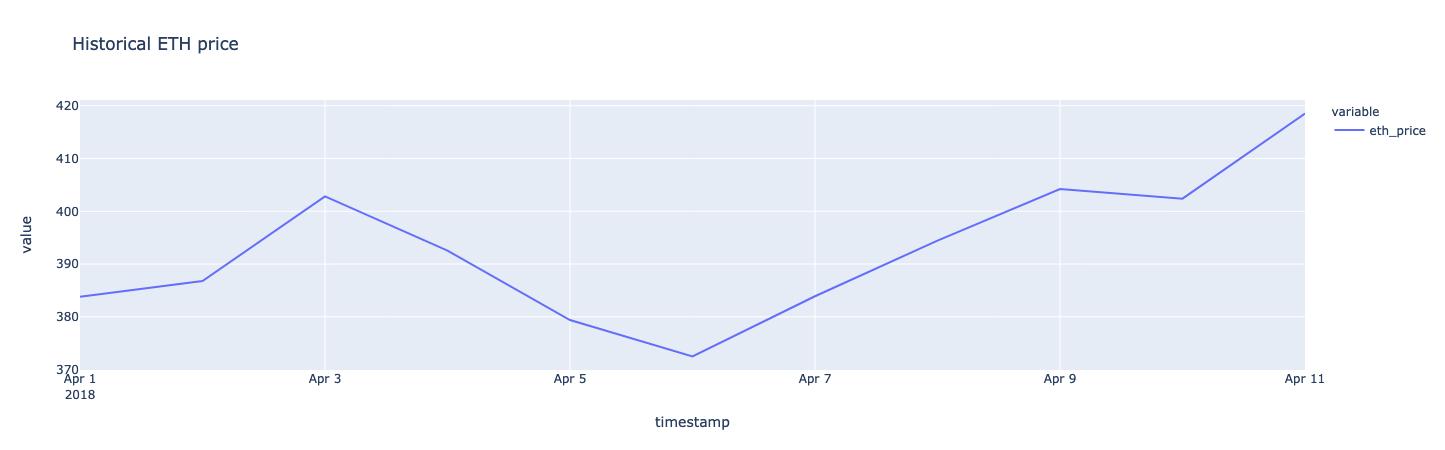

In [15]:
df.plot(x='timestamp', y=['eth_price'], title='Historical ETH price')

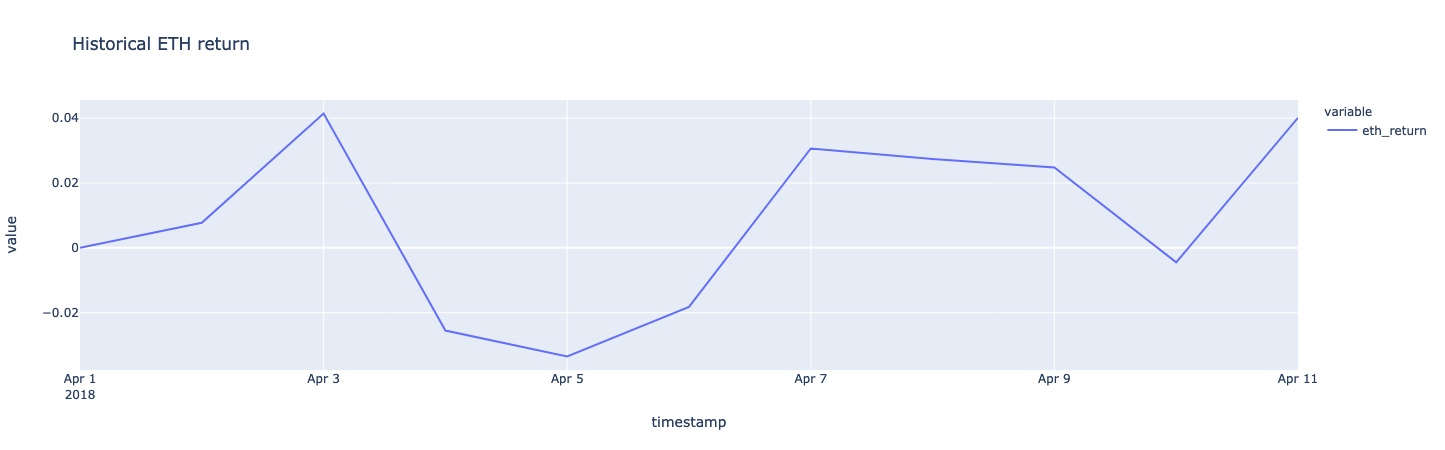

In [16]:
df.plot(x='timestamp', y=['eth_return'], title='Historical ETH return')

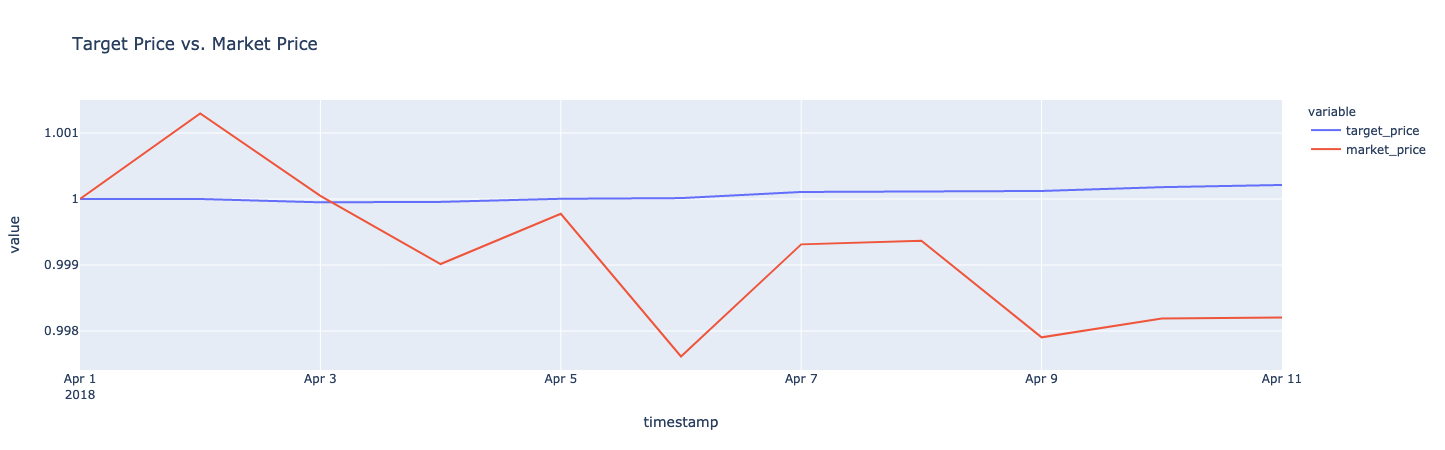

In [17]:
df.plot(x='timestamp', y=['target_price', 'market_price'], title='Target Price vs. Market Price')

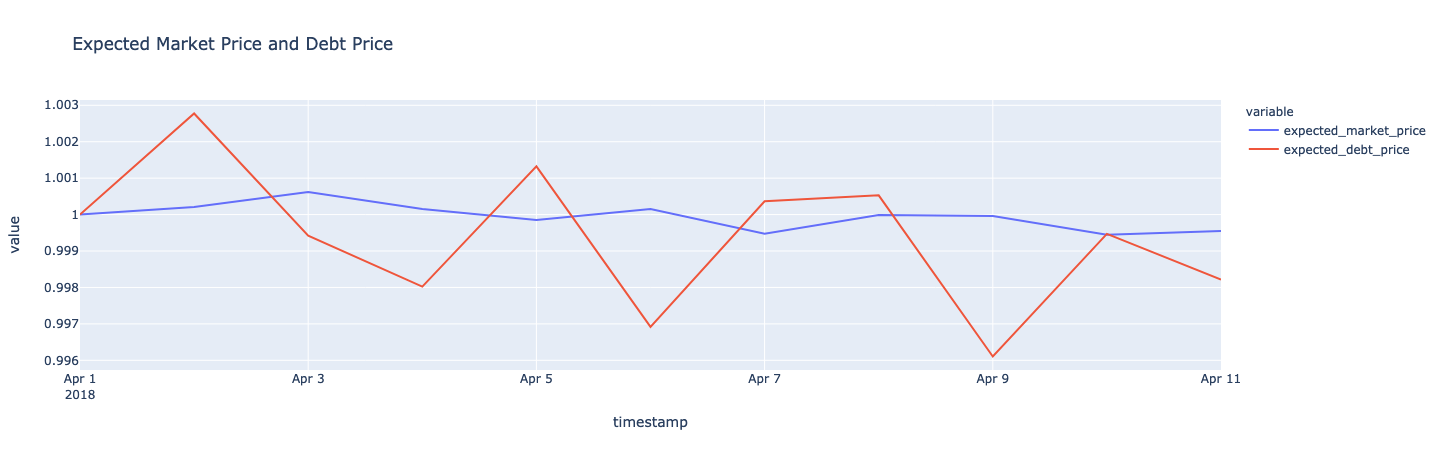

In [18]:
df.plot(x='timestamp', y=['expected_market_price', 'expected_debt_price'], title='Expected Market Price and Debt Price')

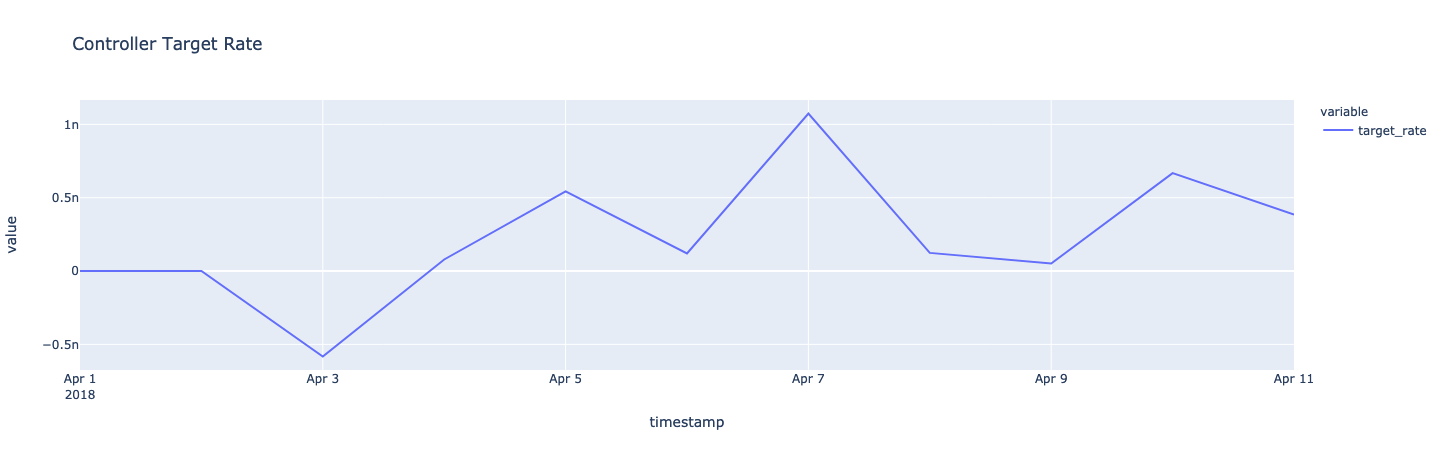

In [19]:
df.plot(x='timestamp', y=['target_rate'], title='Controller Target Rate')

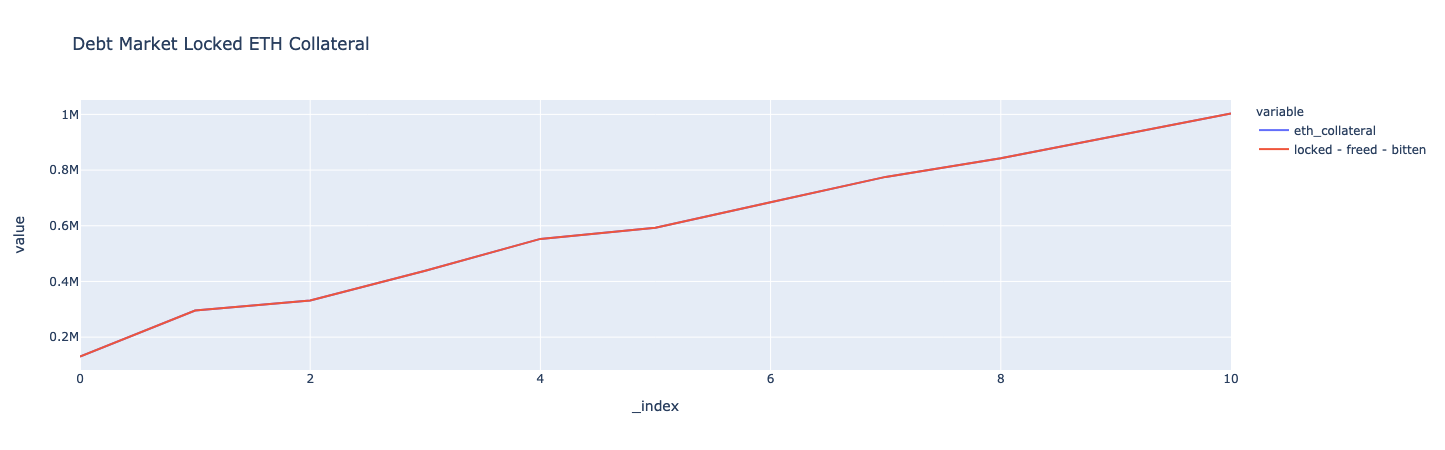

In [20]:
df['locked - freed - bitten'] = df['eth_locked'] - df['eth_freed'] - df['eth_bitten']
df.plot(y=['eth_collateral', 'locked - freed - bitten'], title='Debt Market Locked ETH Collateral')

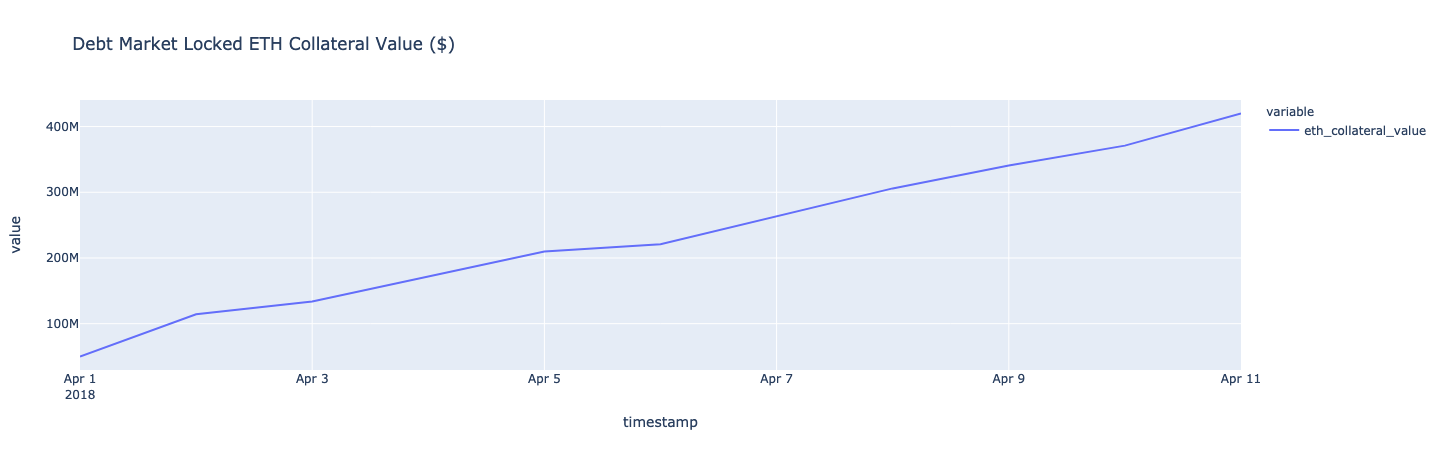

In [21]:
df.plot(x='timestamp', y=['eth_collateral_value'], title='Debt Market Locked ETH Collateral Value ($)')

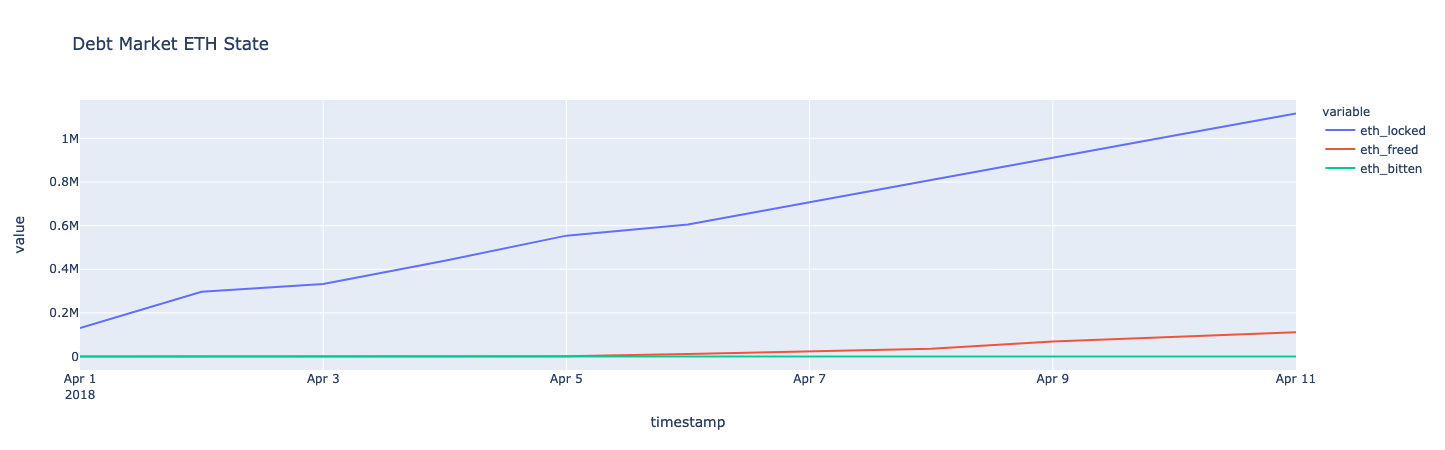

In [22]:
df.plot(x='timestamp', y=['eth_locked', 'eth_freed', 'eth_bitten'], title='Debt Market ETH State')

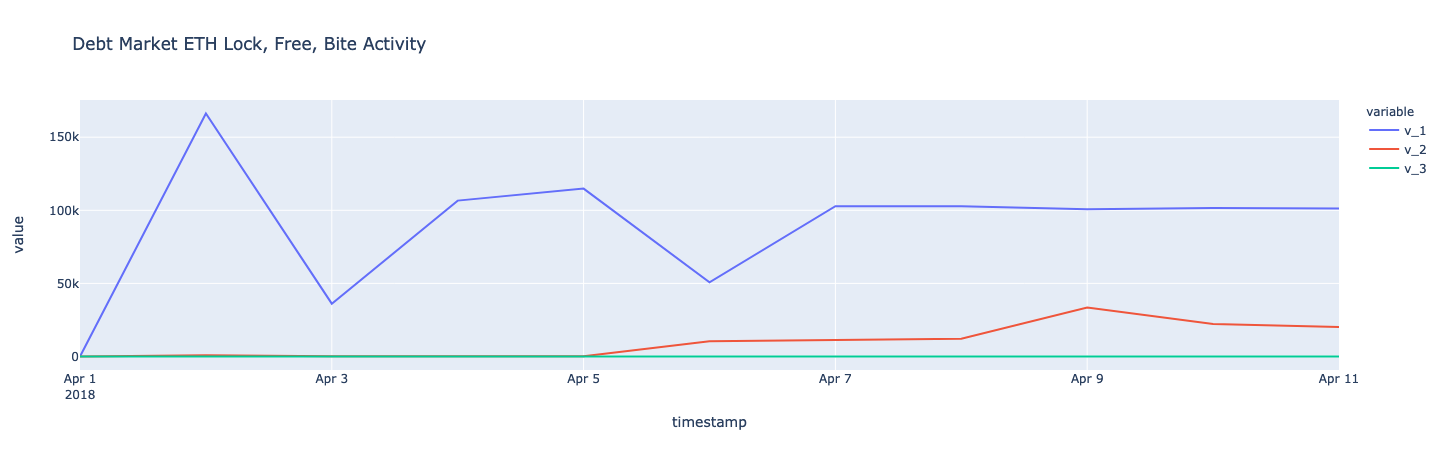

In [23]:
df.plot(x='timestamp', y=['v_1', 'v_2', 'v_3'], title='Debt Market ETH Lock, Free, Bite Activity')

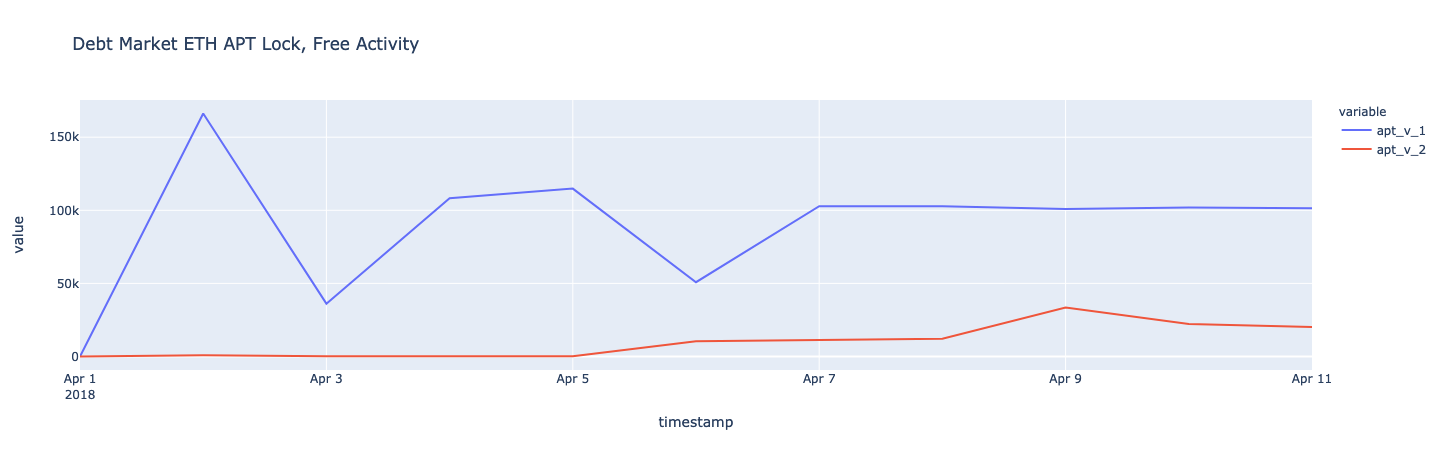

In [24]:
df['apt_v_1'] = df['optimal_values'].map(lambda v: v.get('v_1', 0))
df['apt_v_2'] = df['optimal_values'].map(lambda v: v.get('v_2 + v_3', 0))

df.plot(x='timestamp', y=['apt_v_1', 'apt_v_2'], title='Debt Market ETH APT Lock, Free Activity')

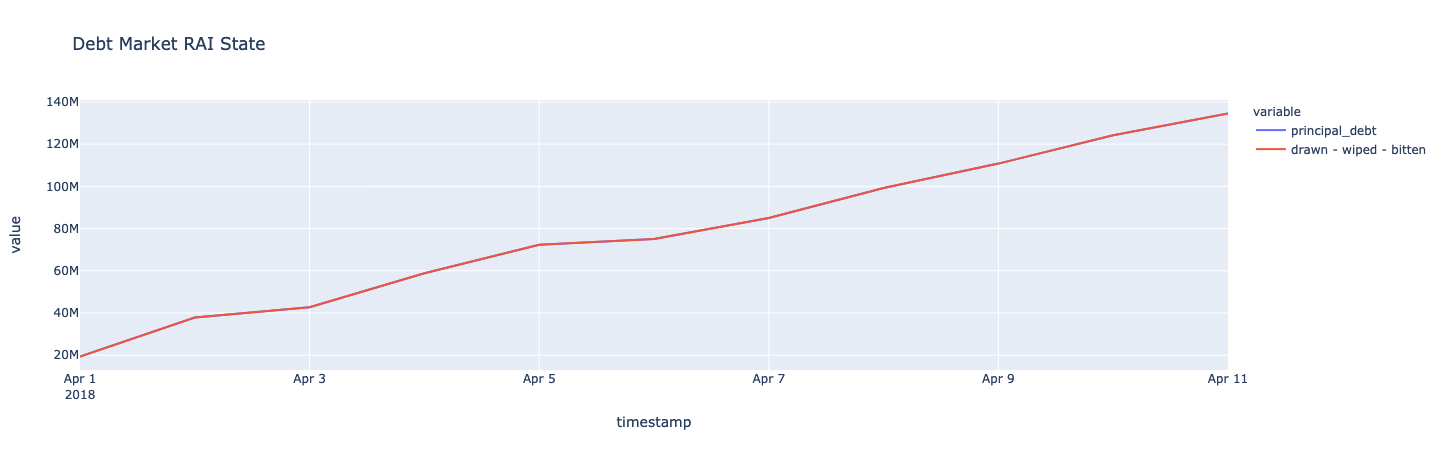

In [25]:
df['drawn - wiped - bitten'] = df['rai_drawn'] - df['rai_wiped'] - df['rai_bitten']
df.plot(x='timestamp', y=['principal_debt', 'drawn - wiped - bitten'], title='Debt Market RAI State')

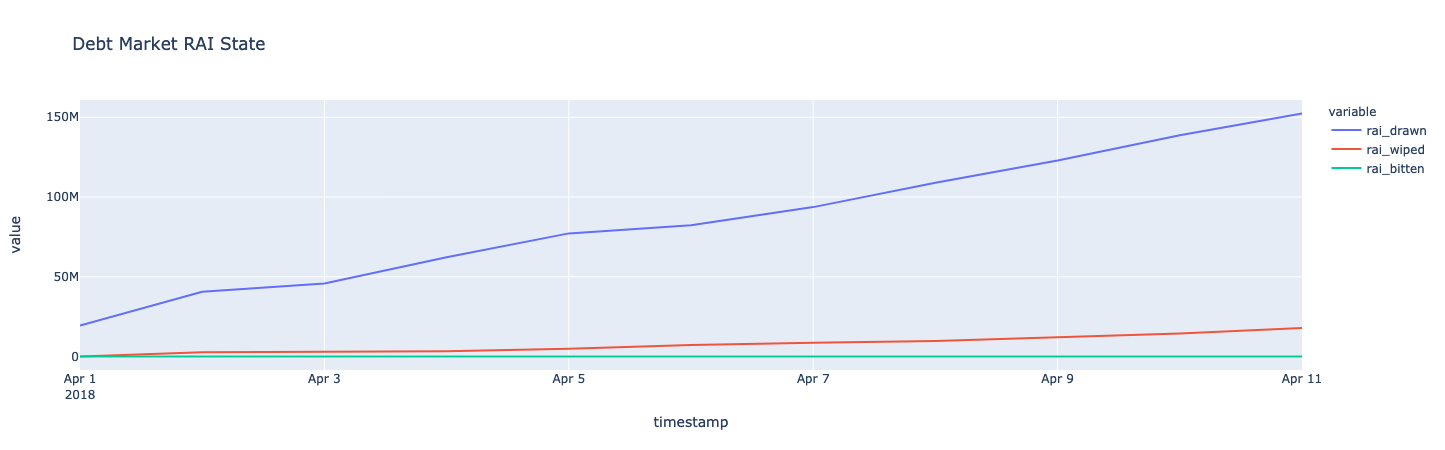

In [26]:
df.plot(x='timestamp', y=['rai_drawn', 'rai_wiped', 'rai_bitten'], title='Debt Market RAI State')

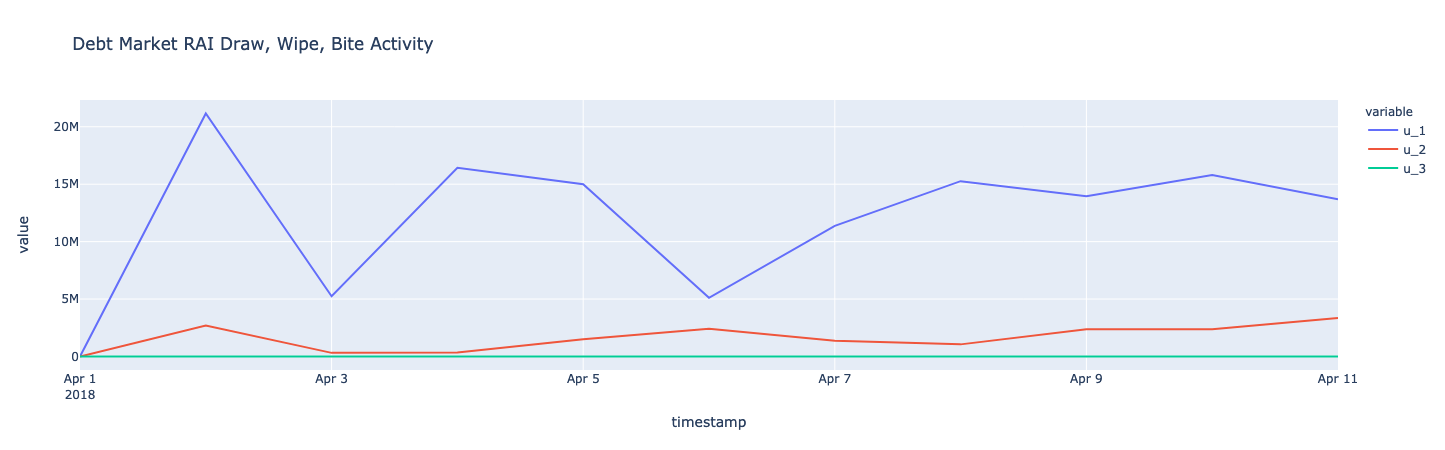

In [27]:
df.plot(x='timestamp', y=['u_1', 'u_2', 'u_3'], title='Debt Market RAI Draw, Wipe, Bite Activity')

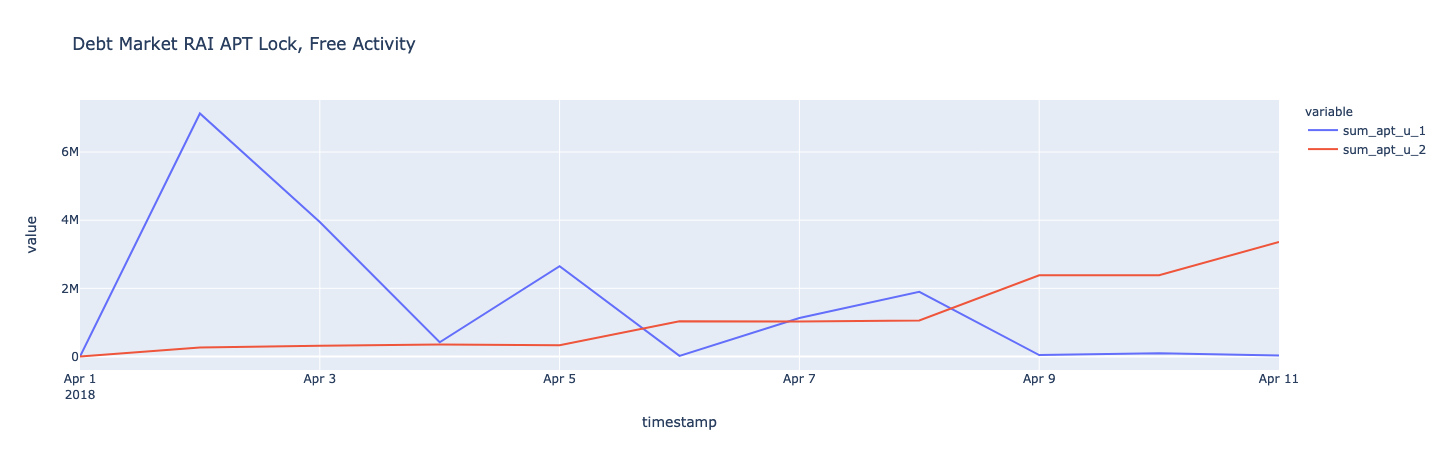

In [28]:
df['sum_apt_u_1'] = df['optimal_values'].map(lambda v: v.get('u_1', 0))
df['sum_apt_u_2'] = df['optimal_values'].map(lambda v: v.get('u_2', 0))

df.plot(x='timestamp', y=['sum_apt_u_1', 'sum_apt_u_2'], title='Debt Market RAI APT Lock, Free Activity')

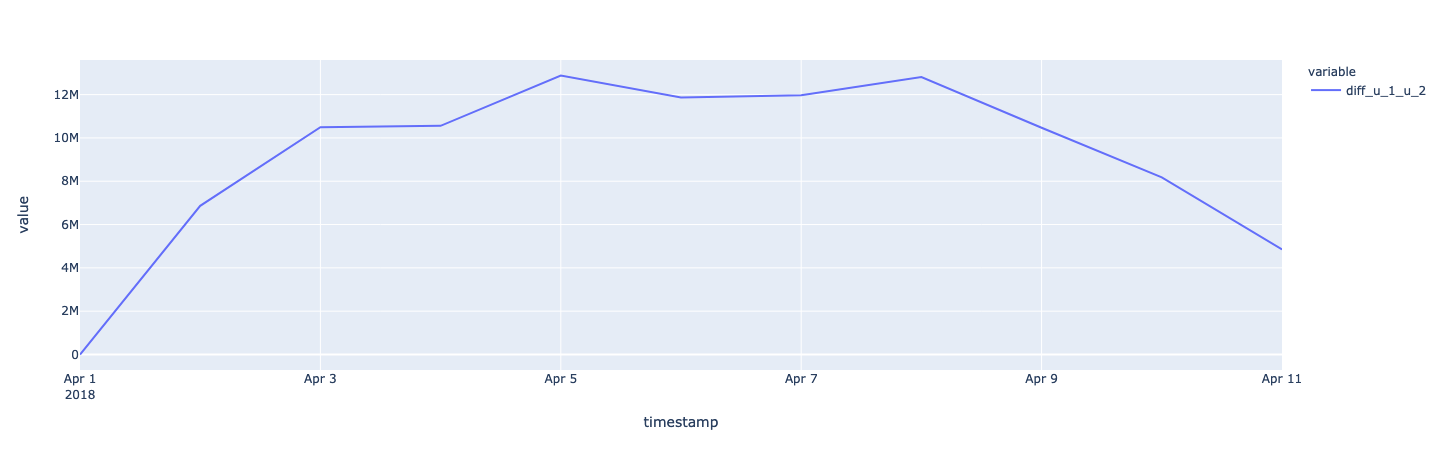

In [29]:
df['diff_u_1_u_2'] = df['sum_apt_u_1'] - df['sum_apt_u_2']
df['diff_u_1_u_2'] = df['diff_u_1_u_2'].cumsum()

df.plot(x='timestamp', y=['diff_u_1_u_2'])

## Accrued interest and system revenue

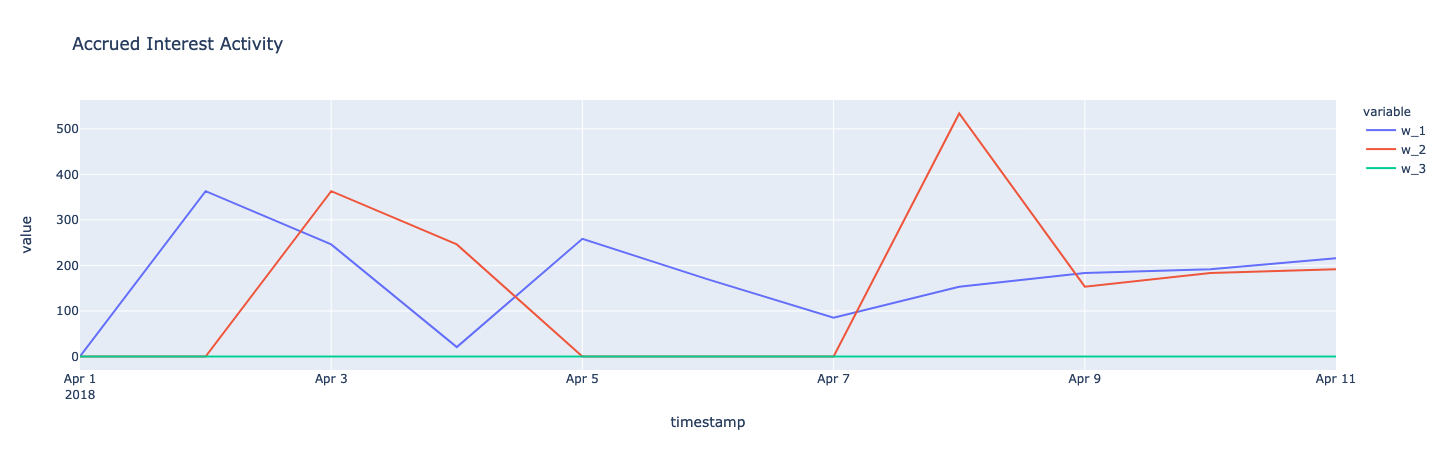

In [30]:
df.plot(x='timestamp', y=['w_1', 'w_2', 'w_3'], title='Accrued Interest Activity')

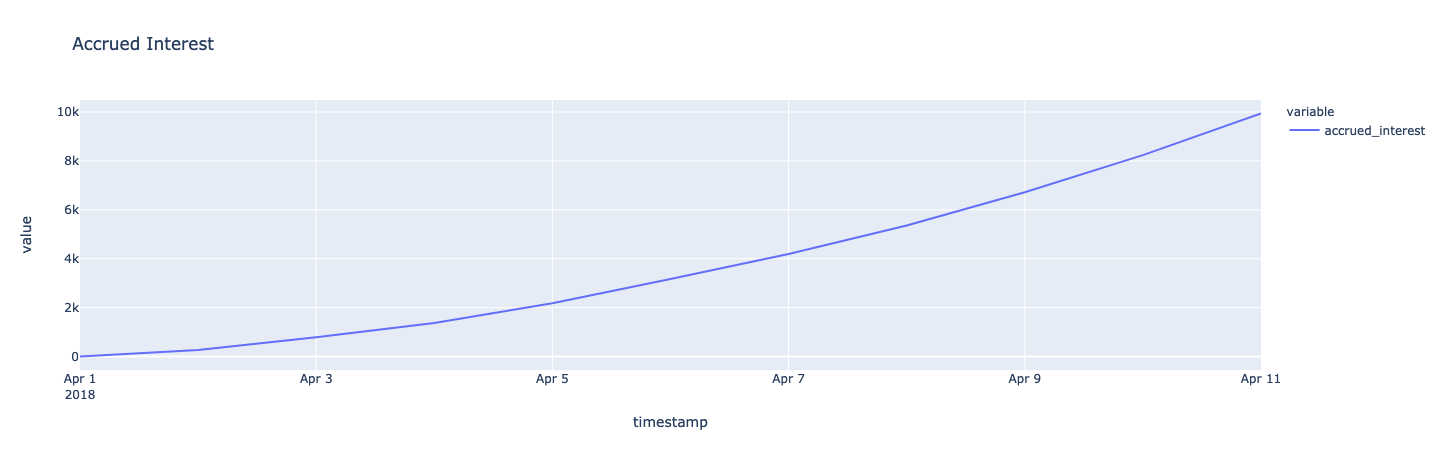

In [31]:
df.plot(x='timestamp', y=['accrued_interest'], title='Accrued Interest')

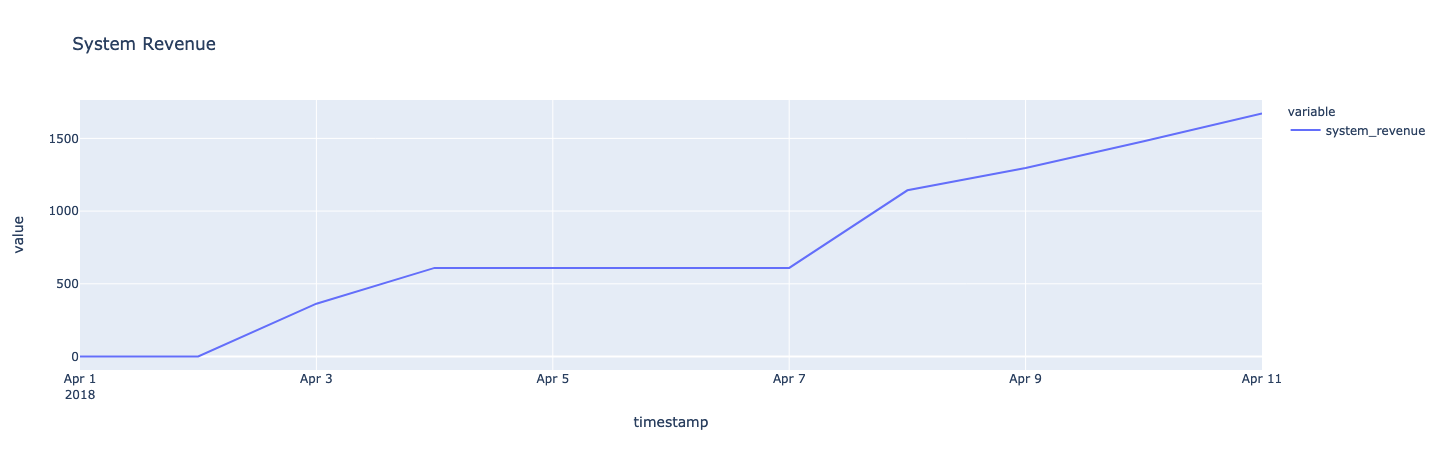

In [32]:
df.plot(x='timestamp', y=['system_revenue'], title='System Revenue')

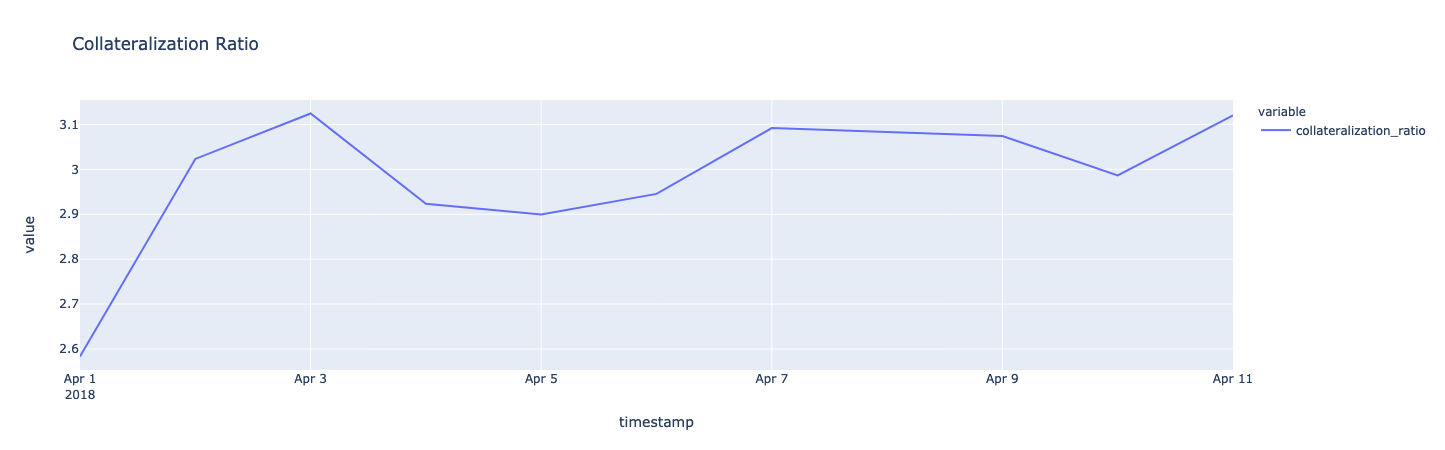

In [33]:
df.plot(x='timestamp', y=['collateralization_ratio'], title='Collateralization Ratio')

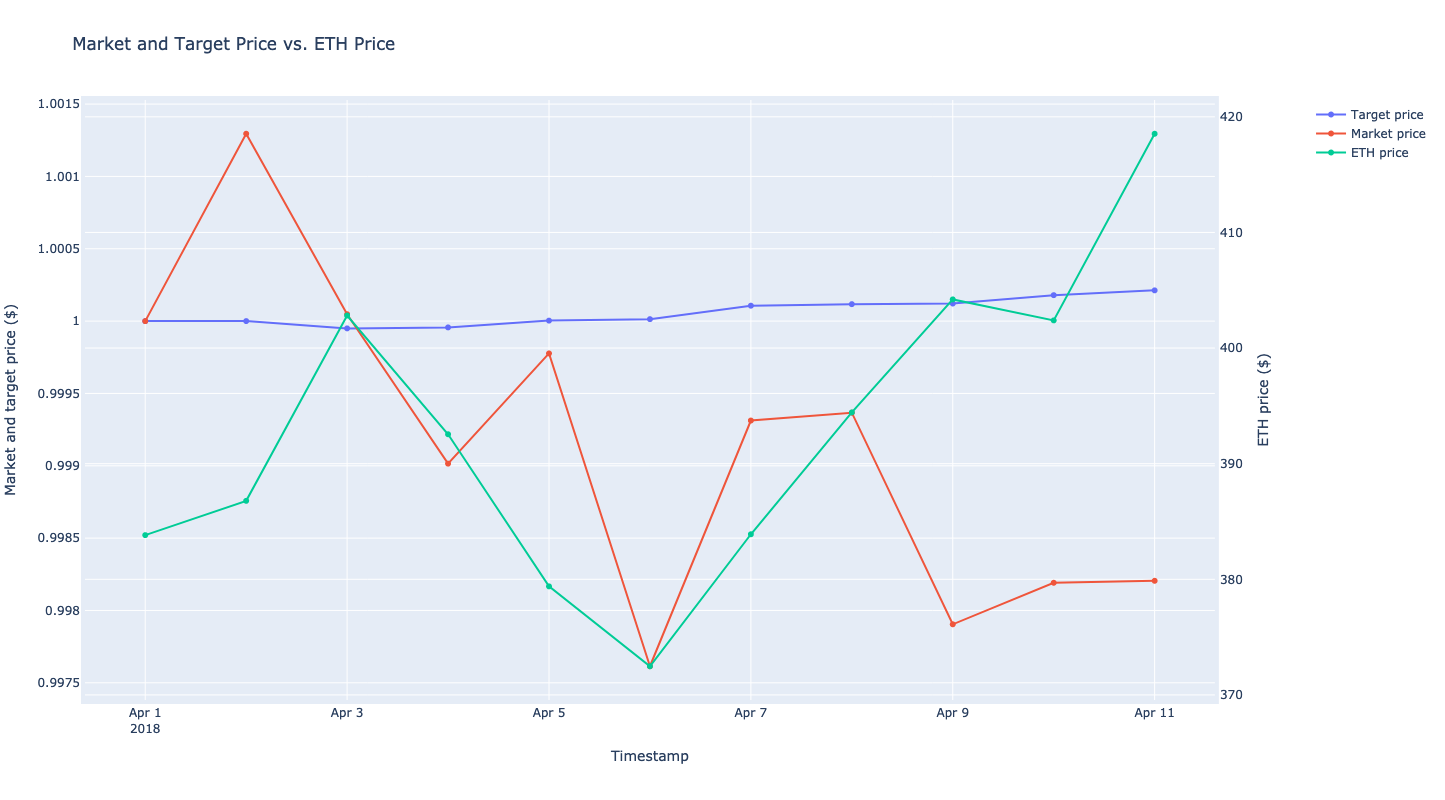

In [34]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Target price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price'], name="Market price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['eth_price'], name="ETH price"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Market and Target Price vs. ETH Price"
)

# Set x-axis title
fig.update_xaxes(title_text="Timestamp")

# Set y-axes titles
fig.update_yaxes(title_text="Market and target price ($)", secondary_y=False)
fig.update_yaxes(title_text="ETH price ($)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

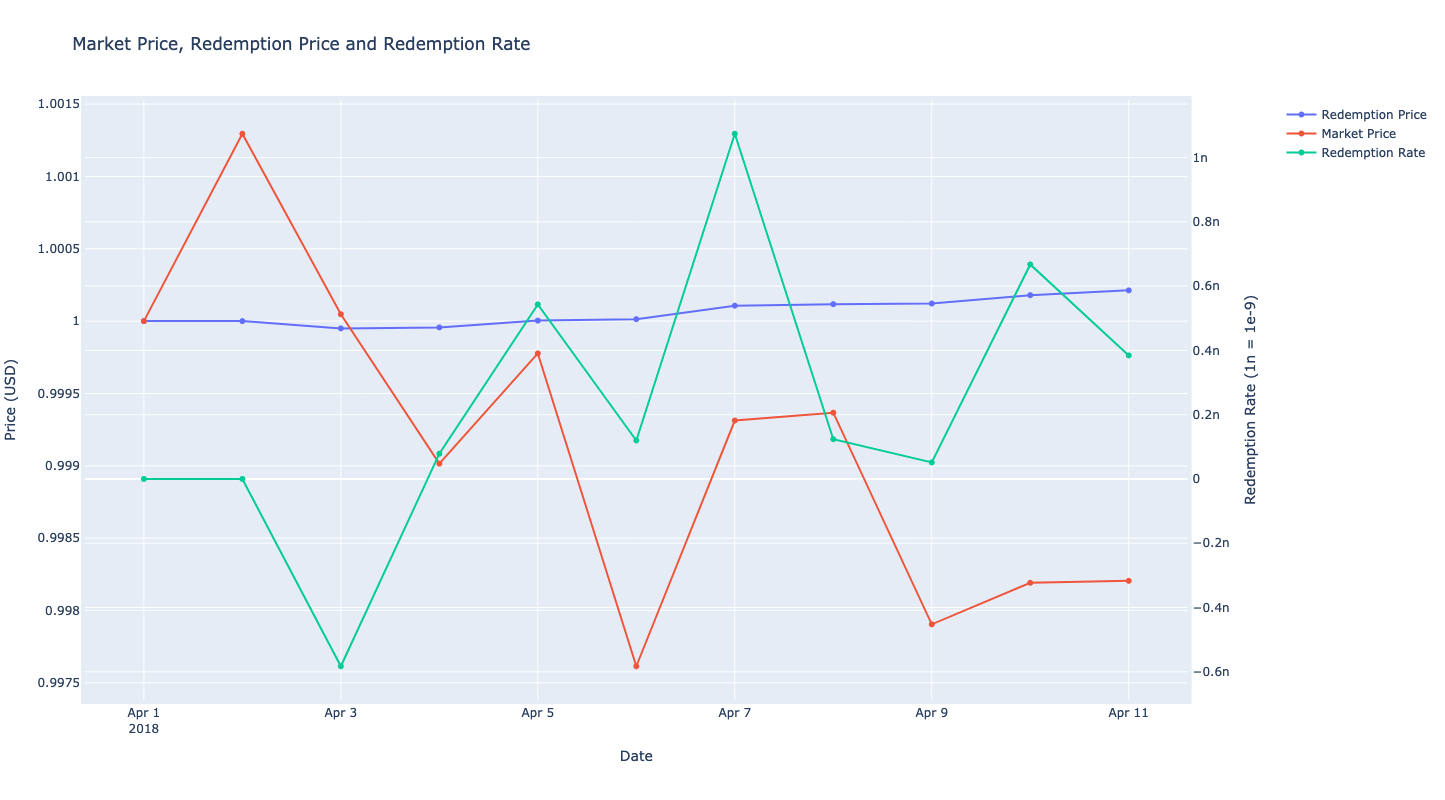

In [35]:

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_price'], name="Redemption Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['market_price'], name="Market Price"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df['timestamp'], y=df['target_rate'], name="Redemption Rate"),
    secondary_y=True,
)
# Add figure title
fig.update_layout(
    title_text="Market Price, Redemption Price and Redemption Rate"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Redemption Rate (1n = 1e-9)", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig.show()

## Simulation statistics

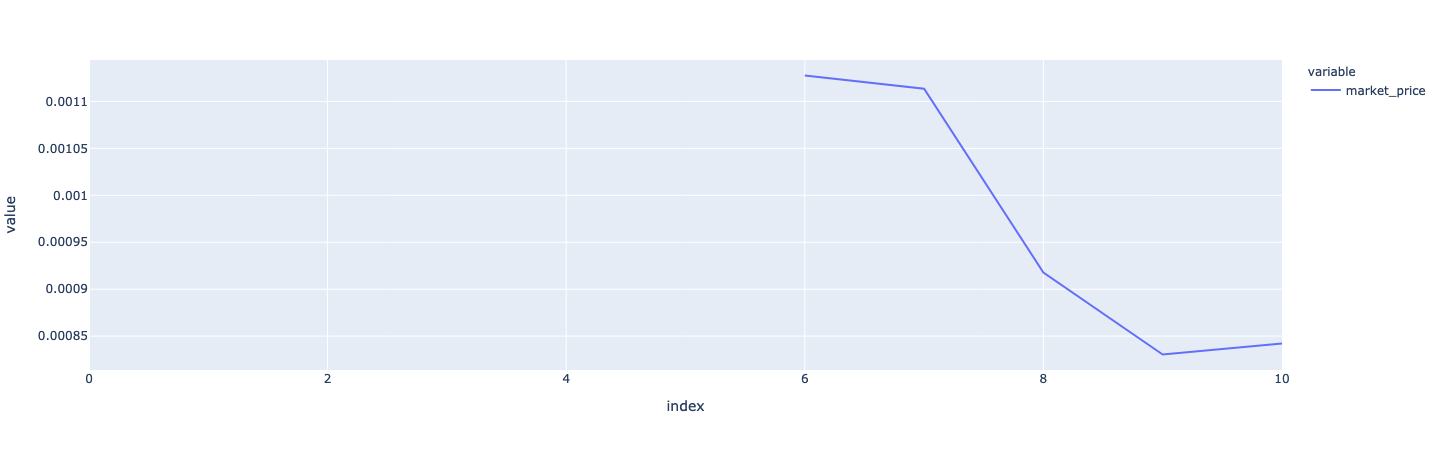

In [36]:
std_mkt = df['market_price'].rolling(7).std()
std_mkt.plot()

In [37]:
np.std(df['market_price'])

0.0010589472714505046

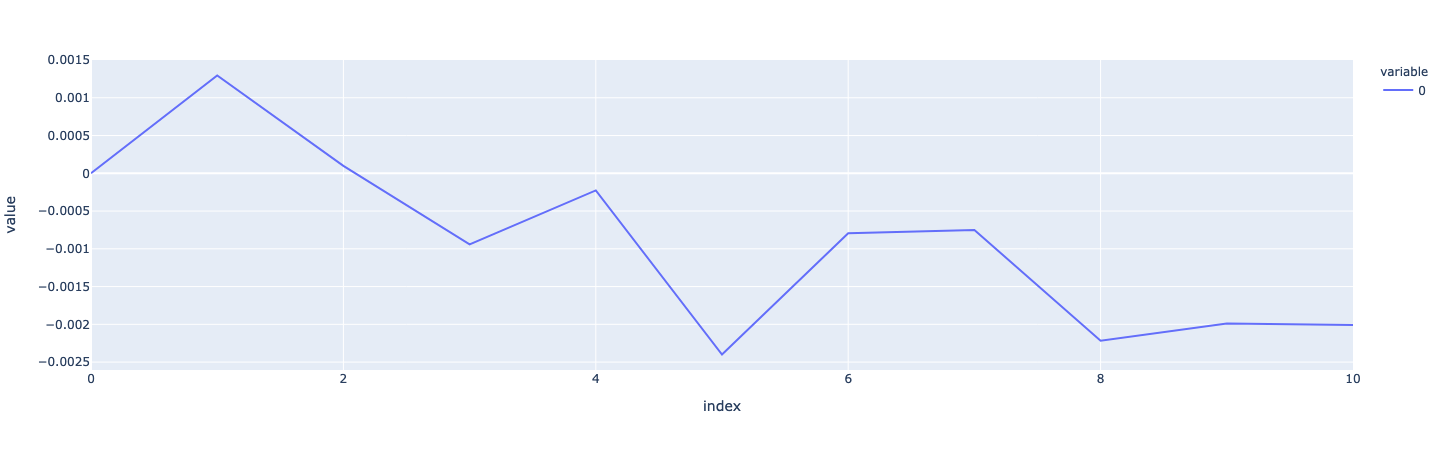

In [38]:
err_m_t = df['market_price'] - df['target_price']
err_m_t.plot()

In [39]:
np.sqrt(abs(df['market_price'] - df['target_price']).mean())

0.03400198979987952

In [40]:
np.corrcoef(df['market_price'],df['eth_price'])

array([[ 1.        , -0.25356927],
       [-0.25356927,  1.        ]])

In [41]:
np.corrcoef(df['market_price'],df['target_price'])

array([[ 1.        , -0.54078962],
       [-0.54078962,  1.        ]])

In [42]:
np.corrcoef(df['market_price'],df['target_rate'])

array([[ 1.        , -0.26240989],
       [-0.26240989,  1.        ]])

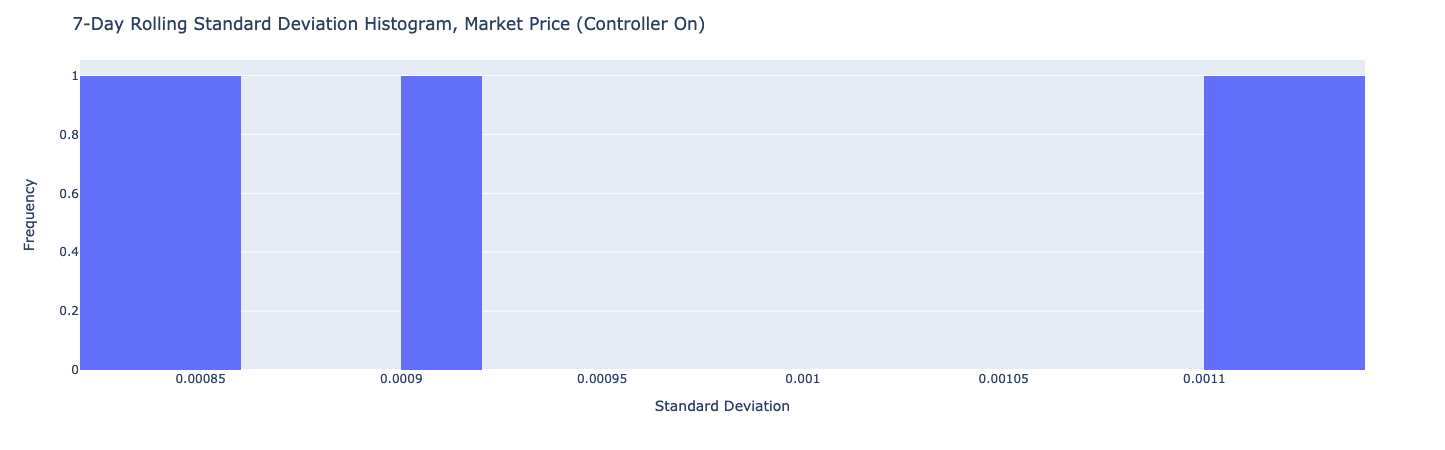

In [43]:

df['market_price_rolling'] = df['market_price'].rolling(7).std()
fig = px.histogram(df, x="market_price_rolling", nbins=25)

fig.update_layout(
    title="7-Day Rolling Standard Deviation Histogram, Market Price (Controller On)",
    xaxis_title="Standard Deviation",
    yaxis_title="Frequency",
)

fig.show()

In [44]:

# std_mkt_without = res_without_controller[‘market_price’].rolling(7).std()
# std_mkt_with = res_with_controller[‘market_price’].rolling(7).std()
# df =pd.DataFrame(dict(
#     series=np.concatenate(([“With Controller”]*len(std_mkt_with), [“Without Controller”]*len(std_mkt_without))),
#     data  =np.concatenate((std_mkt_with,std_mkt_without))
# ))

# fig = df.hist(x=“data”, color=“series”, nbins=25, barmode=“overlay”,
#         labels={
#             ‘count’ : “Count”,
#             ‘data’ : “Std Dev”,
#             ‘series’ : “Simulation”
#         },
#         title=“Histogram, Standard Deviations of Market Price”)
# fig.show()